Sampling priors...


Output()

Output()

Output()

Output()


Prior model comparison:
Error comparing models: Encountered error in ic computation of compare.


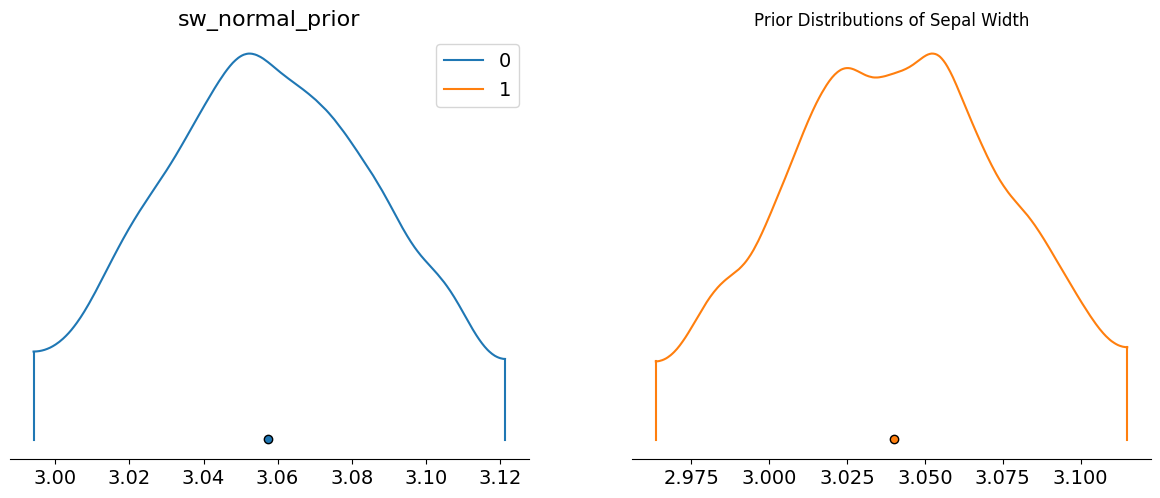


Species-specific analysis...


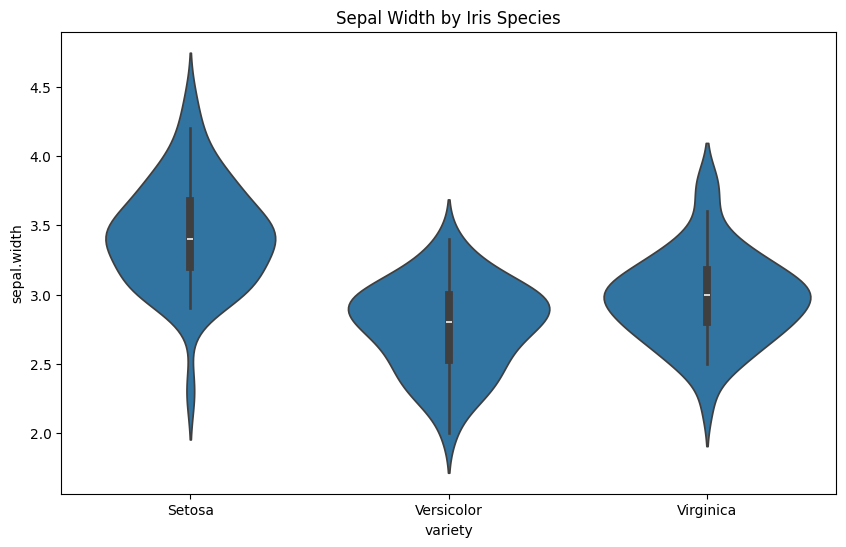

Output()

Output()

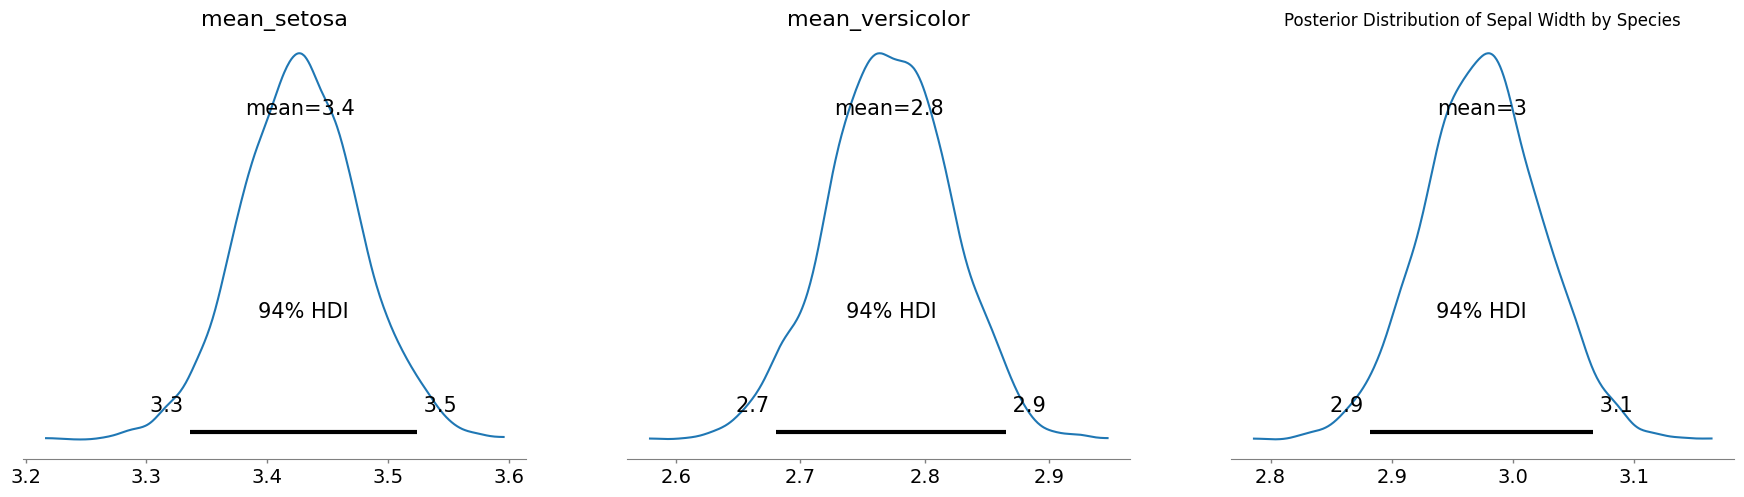


Species comparison results:
                Comparison  Cohen's d  Probability of Superiority
0     Setosa vs Versicolor   1.890995                      0.9056
1      Setosa vs Virginica   1.290070                      0.8044
2  Versicolor vs Virginica  -0.641152                      0.2896


In [5]:
# Import necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Load the dataset
iris_data = pd.read_csv('/content/iris.csv')

# Part A: Define Priors and Sample
def define_priors():
    # Calculate mean and standard deviation of sepal width
    sepal_width_mean = iris_data['sepal.width'].mean()
    sepal_width_stddev = iris_data['sepal.width'].std()

    # Normal prior model
    with pm.Model() as normal_prior_model:
        normal_prior = pm.Normal('sw_normal_prior', mu=sepal_width_mean, sigma=sepal_width_stddev)
        normal_obs = pm.Normal('sw_likelihood_normal', mu=normal_prior, sigma=sepal_width_stddev, observed=iris_data['sepal.width'])
        normal_samples = pm.sample(2000, tune=1000, return_inferencedata=True)

    # Student's T prior model
    with pm.Model() as student_prior_model:
        student_prior = pm.StudentT('sw_student_prior', nu=3, mu=sepal_width_mean, sigma=sepal_width_stddev)
        student_obs = pm.StudentT('sw_likelihood_student', nu=3, mu=student_prior, sigma=sepal_width_stddev, observed=iris_data['sepal.width'])
        student_samples = pm.sample(2000, tune=1000, return_inferencedata=True)

    return normal_samples, student_samples

# Part B: Visualization and Bayesian Analysis by Species
def species_analysis():
    # Violin plot for sepal width by species
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=iris_data, x='variety', y='sepal.width')
    plt.title('Sepal Width by Iris Species')
    plt.show()

    # Separate data by species
    species_groups = {
        'setosa': iris_data[iris_data['variety'] == 'Setosa']['sepal.width'],
        'versicolor': iris_data[iris_data['variety'] == 'Versicolor']['sepal.width'],
        'virginica': iris_data[iris_data['variety'] == 'Virginica']['sepal.width']
    }

    # Define a hierarchical model to analyze each species
    with pm.Model() as species_hierarchical_model:
        avg_sepal_width = pm.Normal('avg_sepal_width', mu=3, sigma=1)
        group_sd = pm.HalfNormal('group_sd', sigma=1)

        # Define species effects for each group
        species_offset = pm.Normal('species_offset', mu=0, sigma=1, shape=3)

        # Calculated means for each species group
        mean_setosa = pm.Deterministic('mean_setosa', avg_sepal_width + species_offset[0])
        mean_versicolor = pm.Deterministic('mean_versicolor', avg_sepal_width + species_offset[1])
        mean_virginica = pm.Deterministic('mean_virginica', avg_sepal_width + species_offset[2])

        # Observations for each species
        setosa_obs = pm.Normal('setosa_obs', mu=mean_setosa, sigma=group_sd, observed=species_groups['setosa'])
        versicolor_obs = pm.Normal('versicolor_obs', mu=mean_versicolor, sigma=group_sd, observed=species_groups['versicolor'])
        virginica_obs = pm.Normal('virginica_obs', mu=mean_virginica, sigma=group_sd, observed=species_groups['virginica'])

        species_trace = pm.sample(2000, tune=1000, return_inferencedata=True)

    return species_trace, species_groups

# Part C: Statistical Comparison of Species Groups
def evaluate_species_groups(species_groups):
    group_comparisons = [('setosa', 'versicolor'), ('setosa', 'virginica'), ('versicolor', 'virginica')]

    comparison_results = []
    for group1, group2 in group_comparisons:
        # Cohen's d for effect size
        effect_size = calculate_cohens_d(species_groups[group1], species_groups[group2])

        # Probability of superiority
        superiority_prob = calculate_prob_superiority(species_groups[group1], species_groups[group2])

        comparison_results.append({
            'Comparison': f'{group1.capitalize()} vs {group2.capitalize()}',
            "Cohen's d": effect_size,
            'Probability of Superiority': superiority_prob
        })

    return pd.DataFrame(comparison_results)

# Helper function for Cohen's d calculation
def calculate_cohens_d(data1, data2):
    size1, size2 = len(data1), len(data2)
    var1, var2 = data1.var(), data2.var()
    pooled_sd = np.sqrt(((size1 - 1) * var1 + (size2 - 1) * var2) / (size1 + size2 - 2))
    return (data1.mean() - data2.mean()) / pooled_sd

# Helper function for probability of superiority
def calculate_prob_superiority(data1, data2):
    return np.mean([1 if x > y else 0 for x in data1 for y in data2])

# Main Function to Execute Code
def main():
    print("Sampling priors...")
    normal_trace, student_trace = define_priors()

    # Store traces for comparison
    prior_models = {'Normal Model': normal_trace, 'Student-T Model': student_trace}

    print("\nPrior model comparison:")
    try:
        model_comparison = az.compare(prior_models)
        print(model_comparison)
    except Exception as error:
        print("Error comparing models:", error)

    # Plot density comparison of priors
    az.plot_density([normal_trace, student_trace], var_names=['sw_normal_prior', 'sw_student_prior'])
    plt.title('Prior Distributions of Sepal Width')
    plt.show()

    # Part B: Species-specific analysis
    print("\nSpecies-specific analysis...")
    trace_species, species_data = species_analysis()

    # Plot posterior distributions for species means
    az.plot_posterior(trace_species, var_names=['mean_setosa', 'mean_versicolor', 'mean_virginica'])
    plt.title('Posterior Distribution of Sepal Width by Species')
    plt.show()

    # Part C: Inter-group comparisons
    print("\nSpecies comparison results:")
    comparison_df = evaluate_species_groups(species_data)
    print(comparison_df)

if __name__ == "__main__":
    main()
